In [1]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## ASVspoof2019 eval

In [2]:
# load dev set
eval_df = pd.read_csv("DATA/asvspoof_2019_supcon/protocol.txt", sep=" ", header=None)
eval_df.columns = ["sid", "utt","phy", "attack", "label"]
eval_df = eval_df[eval_df['utt'].str.contains("LA_E")]
eval_df.head


<bound method NDFrame.head of            sid           utt phy attack     label
23092  LA_0039  LA_E_2834763   -    A11     spoof
23093  LA_0014  LA_E_8877452   -    A14     spoof
23094  LA_0040  LA_E_6828287   -    A16     spoof
23095  LA_0022  LA_E_6977360   -    A09     spoof
23096  LA_0031  LA_E_5932896   -    A13     spoof
...        ...           ...  ..    ...       ...
94324  LA_0004  LA_E_1665632   -      -  bonafide
94325  LA_0038  LA_E_5085671   -    A09     spoof
94326  LA_0012  LA_E_4926022   -    A16     spoof
94327  LA_0052  LA_E_2894498   -      -  bonafide
94328  LA_0009  LA_E_4689563   -    A19     spoof

[71237 rows x 5 columns]>

### conf-3-linear

EER: 2.8837%, threshold: -0.0017


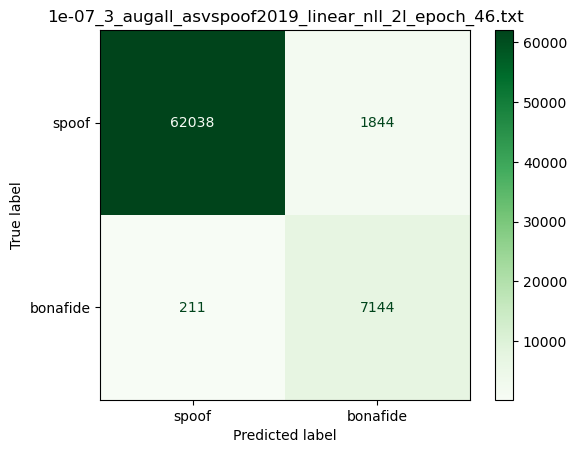

In [3]:
pred_df = pd.read_csv("docs/1e-07_3_augall_asvspoof2019_linear_nll_2l_epoch_46.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score","pred"]

pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("1e-07_3_augall_asvspoof2019_linear_nll_2l_epoch_46.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


In [4]:
res_df[(res_df['label'] == 'spoof') & (res_df['score'] > -0.1)]['attack'].value_counts()

A10    4102
A16    1212
A12     384
A11      72
A19      72
A14      50
A15      24
A17      22
A07      10
A18       2
A08       2
Name: attack, dtype: int64

-0.0007096394547261 -7.467826843261719


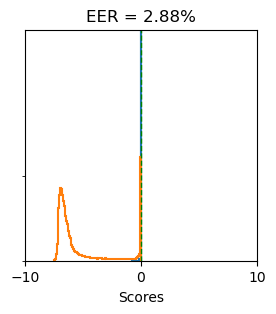

In [5]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100))

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([-10,0,10])
plt.yticks([])
plt.ylim(0,5)
plt.rcParams.update({'font.size': 16})
# Displaying the plot
plt.show()


### conf-3-resnet

EER: 3.2896%, threshold: 5.0272


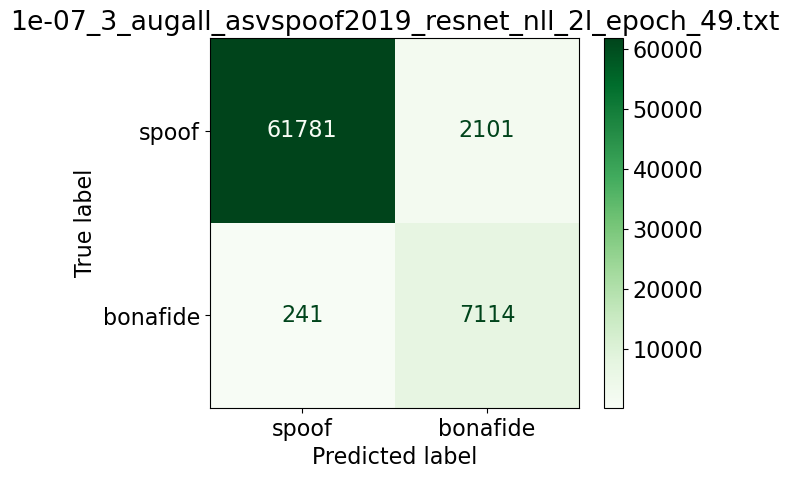

In [6]:
pred_df = pd.read_csv("docs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score","pred"]

pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


In [7]:
res_df[(res_df['label'] == 'spoof') & (res_df['score'] > -0.1)]['attack'].value_counts()

A10    4487
A16    1667
A12     819
A14     385
A19     223
A15     210
A11     151
A07      98
A08      64
A17      24
A18       3
A09       1
Name: attack, dtype: int64

5.04769229888916 -4.882542610168457


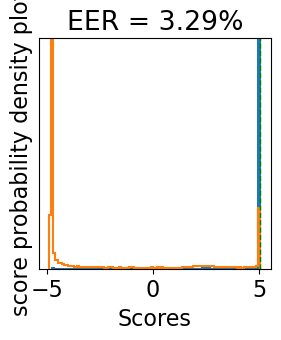

In [8]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100))

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([-5,0,5])
plt.yticks([])
plt.ylim(0,2)
plt.rcParams.update({'font.size': 16})
# Displaying the plot
plt.show()


## ASVspoof 2021 DF

In [9]:
# load DF 2021 set
DF_df = pd.read_csv("DATA/asvspoof_2021_DF/trial_metadata.txt", sep=" ", header=None)
DF_df.columns = ["sid", "utt","codec", "src", "attack", "label", "trim", "subset","vocoder","b","c","d","e"]

DF_df.head


<bound method NDFrame.head of             sid           utt     codec       src        attack  label  \
0       LA_0023  DF_E_2000011   nocodec  asvspoof           A14  spoof   
1          TEF2  DF_E_2000013   low_m4a   vcc2020  Task1-team20  spoof   
2          TGF1  DF_E_2000024    mp3m4a   vcc2020  Task2-team12  spoof   
3       LA_0043  DF_E_2000026    mp3m4a  asvspoof           A09  spoof   
4       LA_0021  DF_E_2000027    mp3m4a  asvspoof           A12  spoof   
...         ...           ...       ...       ...           ...    ...   
611824  VCC2TM2  DF_E_4999945    oggm4a   vcc2018       SPO-N16  spoof   
611825  LA_0044  DF_E_4999962    oggm4a  asvspoof           A19  spoof   
611826  LA_0042  DF_E_4999964  high_ogg  asvspoof           A13  spoof   
611827     TEM1  DF_E_4999980   low_m4a   vcc2020  Task1-team07  spoof   
611828     TGF1  DF_E_4999993    mp3m4a   vcc2020  Task2-team33  spoof   

          trim    subset                           vocoder      b       c   d  \


### conf-3-linear


EER: 2.1730%, threshold: -2.4381


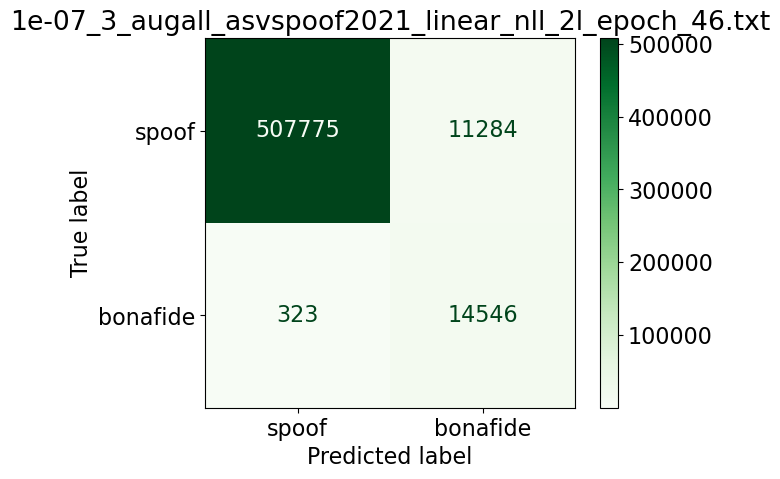

In [10]:

pred_df = pd.read_csv("docs/1e-07_3_augall_asvspoof2021_linear_nll_2l_epoch_46.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score","pred"]

pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("1e-07_3_augall_asvspoof2021_linear_nll_2l_epoch_46.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [11]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred'] == 'bonafide')]['vocoder'].value_counts()

neural_vocoder_autoregressive       8417
waveform_concatenation              1263
traditional_vocoder                 1147
neural_vocoder_nonautoregressive     238
unknown                              219
Name: vocoder, dtype: int64

-0.0007758706342428 -7.685970783233643


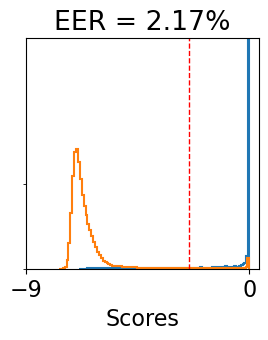

In [12]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100))

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([-9,0])
plt.yticks([])
plt.ylim(0,5)
# Displaying the plot
plt.show()


### conf-3-resnet

EER: 3.2622%, threshold: -4.1554


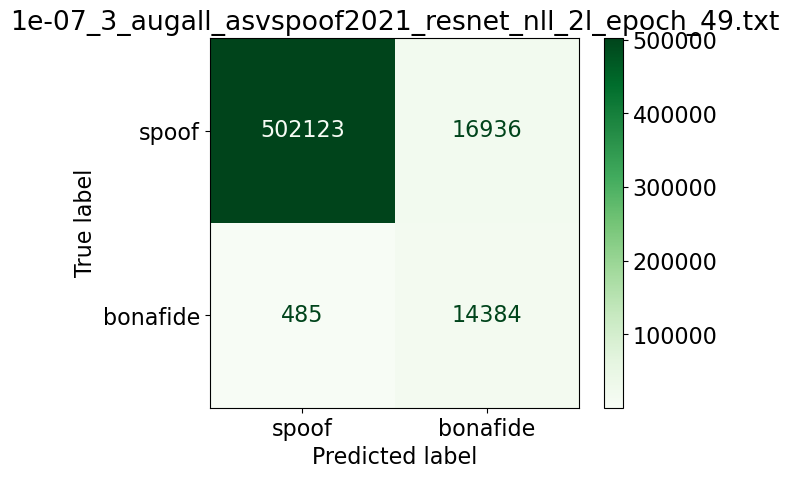

In [13]:

pred_df = pd.read_csv("docs/1e-07_3_augall_asvspoof2021_resnet_nll_2l_epoch_49.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score","pred"]

pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("1e-07_3_augall_asvspoof2021_resnet_nll_2l_epoch_49.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

5.048826217651367 -4.879685401916504


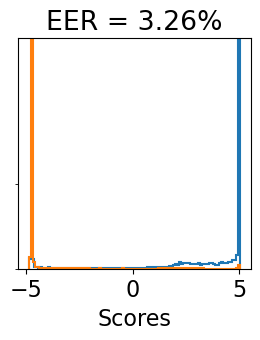

In [14]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100))

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
# plt.axvline(x=threshold, color='r', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([-5,0,5])
plt.yticks([])
plt.ylim(0,5)
# Displaying the plot
plt.show()


## In The Wild

In [15]:
# load in the wild protocol
in_the_wild = pd.read_csv("DATA/in_the_wild/protocol.txt", sep=" ", header=None)
in_the_wild.columns = ['utt', 'subset', 'label']
in_the_wild.head

<bound method NDFrame.head of                  utt subset     label
0          wav/1.wav   eval     spoof
1          wav/2.wav   eval     spoof
2          wav/3.wav   eval     spoof
3          wav/4.wav   eval  bonafide
4          wav/5.wav   eval  bonafide
...              ...    ...       ...
31773  wav/31774.wav   eval  bonafide
31774  wav/31775.wav   eval  bonafide
31775  wav/31776.wav   eval  bonafide
31776  wav/31777.wav   eval  bonafide
31777  wav/31778.wav   eval     spoof

[31778 rows x 3 columns]>

### conf-3-linear

EER: 4.5098%, threshold: -2.0041


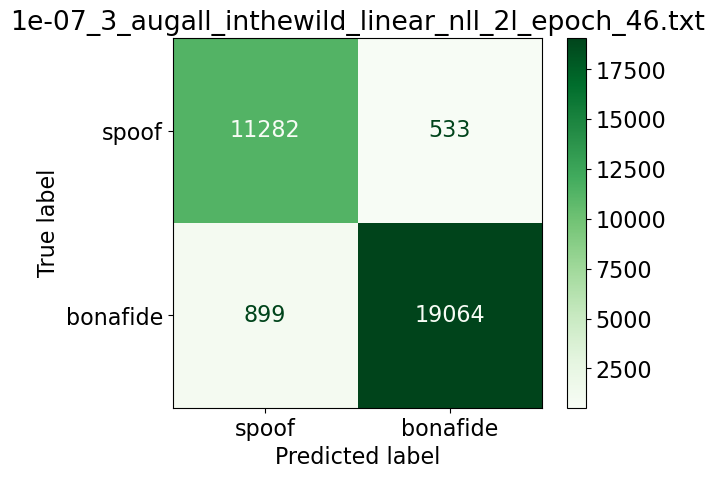

In [16]:
pred_df = pd.read_csv("docs/1e-07_3_augall_inthewild_linear_nll_2l_epoch_46.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score","pred"]

pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(in_the_wild, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("1e-07_3_augall_inthewild_linear_nll_2l_epoch_46.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### conf-3-resnet

EER: 4.8586%, threshold: -4.4565


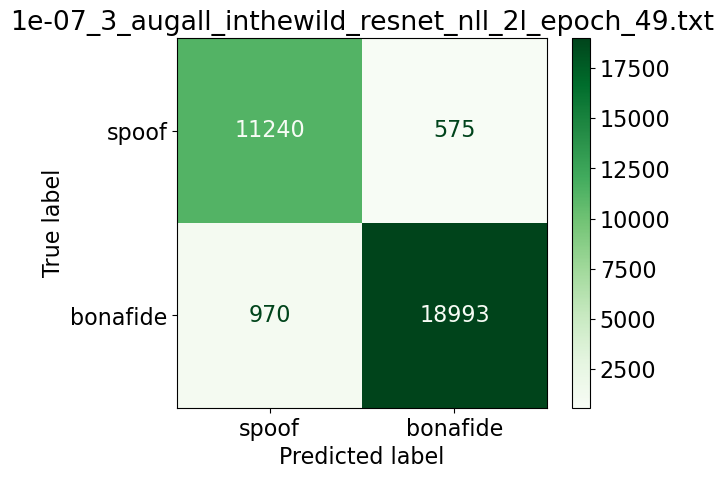

In [17]:
pred_df = pd.read_csv("docs/1e-07_3_augall_inthewild_resnet_nll_2l_epoch_49.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score","pred"]

pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(in_the_wild, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("1e-07_3_augall_inthewild_resnet_nll_2l_epoch_49.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

5.057563781738281 -4.854959011077881
19963 11815


FileNotFoundError: [Errno 2] No such file or directory: 'figs/resnet_2l_epoch_21_inthewild.pdf'

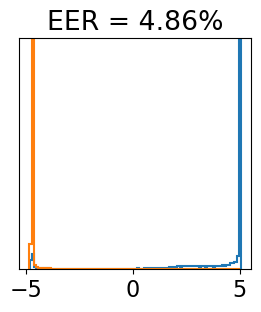

In [18]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']
print(len(bona), len(spoof))

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100))

# Adding a legend
# plt.legend(loc='lower right')

# Set the x-axis tick positions and labels
# plt.axvline(x=threshold, color='r', linestyle='--')
plt.xticks([-5,0,5])
plt.yticks([])
plt.ylim(0,4)
plt.rcParams.update({'font.size': 16})
plt.savefig("figs/resnet_2l_epoch_21_inthewild.pdf", dpi=600)
# Displaying the plot
plt.show()
